<a href="https://colab.research.google.com/github/ChallapalliHemanthsaikumar/personal_rag/blob/main/personal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Why Local ..

Create and run a local RAG pipeline from scratch
The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

There are frameworks that replicate this kind of workflow, including LlamaIndex and LangChain, however, the goal of building from scratch is to be able to inspect and customize all the parts.





What is RAG?
RAG stands for Retrieval Augmented Generation.



It was introduced in the paper Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks.

Each step can be roughly broken down to:

Retrieval - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
Augmented - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
Generation - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.




Why RAG?
The main goal of RAG is to improve the generation outptus of LLMs.

Two primary improvements can be seen as:

Preventing hallucinations - LLMs are incredible but they are prone to potential hallucination, as in, generating something that looks correct but isn't. RAG pipelines can help LLMs generate more factual outputs by providing them with factual (retrieved) inputs. And even if the generated answer from a RAG pipeline doesn't seem correct, because of retrieval, you also have access to the sources where it came from.
Work with custom data - Many base LLMs are trained with internet-scale text data. This means they have a great ability to model language, however, they often lack specific knowledge. RAG systems can provide LLMs with domain-specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.



The authors of the original RAG paper mentioned above outlined these two points in their discussion.

This work offers several positive societal benefits over previous work: the fact that it is more strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less with generations that are more factual, and offers more control and interpretability. RAG could be employed in a wide variety of scenarios with direct benefit to society, for example by endowing it with a medical index and asking it open-domain questions on that topic, or by helping people be more effective at their jobs.

RAG can also be a much quicker solution to implement than fine-tuning an LLM on specific data.




What kind of problems can RAG be used for?
RAG can help anywhere there is a specific set of information that an LLM may not have in its training data (e.g. anything not publicly accessible on the internet).

For example you could use RAG for:

Customer support Q&A chat - By treating your existing customer support documentation as a resource, when a customer asks a question, you could have a system retrieve relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation". Klarna, a large financial company, uses a system like this to save $40M per year on customer support costs.
Email chain analysis - Let's say you're an insurance company with long threads of emails between customers and insurance agents. Instead of searching through each individual email, you could retrieve relevant passages and have an LLM create strucutred outputs of insurance claims.
Company internal documentation chat - If you've worked at a large company, you know how hard it can be to get an answer sometimes. Why not let a RAG system index your company information and have an LLM answer questions you may have? The benefit of RAG is that you will have references to resources to learn more if the LLM answer doesn't suffice.
Textbook Q&A - Let's say you're studying for your exams and constantly flicking through a large textbook looking for answers to your quesitons. RAG can help provide answers as well as references to learn more.
All of these have the common theme of retrieving relevant resources and then presenting them in an understandable way using an LLM.




From this angle, you can consider an LLM a calculator for words.

In [ ]:
## FUN

!nvidia-smi

Mon Apr  1 22:30:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--


## what are we going to build





Here I am going to build indian constitution

Specifically:

1.Open a PDF Document
2.Format the text of the pdf textbook ready for an emebedding model.
3.Embed all of the  chunks of text in the textbook and turn them in to numerical representations which can store for later
4. Build a reterival system that uses vector search to find relevant chunk of text based on a query
5. Create a prompt that incorportes the reterived pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM
All locally!

1. Steps 1-3 Document Preprocessing and embedding Creation
2. Steps 4-6: Search and answer



### 1. Document /text processing and embedding creation

Ingredients:

Steps:

1.Import PDF Document
2.process text for embedding
3. embed text chunks with embedding model
4. Save Emedding to file for later (embeddings will store on file for many years or until you Lose your Hard Drive )



In [ ]:
!pip install requests



Indian Constutition PDF LINK (https://cdnbbsr.s3waas.gov.in/s380537a945c7aaa788ccfcdf1b99b5d8f/uploads/2023/05/2023050195.pdf)

In [ ]:
import os
import requests

pdf_path = "indian_const.pdf"

if not os.path.exists(pdf_path):
  print(f"[INFO] File doesn't exist, downloading...")
  url = "https://cdnbbsr.s3waas.gov.in/s380537a945c7aaa788ccfcdf1b99b5d8f/uploads/2023/05/2023050195.pdf"

  filename = pdf_path

  response = requests.get(url)

  if response.status_code == 200:

    with open(filename,'wb') as file:
      file.write(response.content)
    print(f"[INFO] File has been downloaded and saved as {filename}")
  else:
    print("[INFO] Failed to downloaded ",response.status_code)



[INFO] File doesn't exist, downloading...
[INFO] File has been downloaded and saved as indian_const.pdf


## Listing the Files to check if Pdf is downloaded or not

In [ ]:
!ls

indian_const.pdf  sample_data


## Importing  fitz and install PyMuPDF



In [ ]:
!pip install PyMuPDF
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 49.7 MB/s eta 0:00:00


In [ ]:
import fitz
from tqdm.auto import tqdm


In [ ]:
def text_formatter(text:str) -> str:
  """  Performs minor formatting on text"""
  cleaned_text = text.replace('\n'," ").strip()
  return cleaned_text

def open_and_read_pdf(pdf_path:str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text=text)
    pages_and_texts.append({"page_number": page_number - 30,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_senetence_count_raw": len(text.split('. ')),
                            "page_token_count": len(text)/4,
                            "text": text

                            })

  return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:5]

0it [00:00, ?it/s]

[{'page_number': -30,
  'page_char_count': 56,
  'page_word_count': 17,
  'page_senetence_count_raw': 1,
  'page_token_count': 14.0,
  'text': 'THE CONSTITUTION OF INDIA  [As on       May, 2022]  2022'},
 {'page_number': -29,
  'page_char_count': 972,
  'page_word_count': 239,
  'page_senetence_count_raw': 7,
  'page_token_count': 243.0,
  'text': 'PREFACE    This is the  fifth  pocket size edition of the Constitution of  India in the diglot form. In this edition, the text of the  Constitution of India has been brought up-to-date by  incorporating therein all the amendments up to the Constitution  (One Hundred and Fifth Amendment) Act, 2021. The foot notes  below the text indicate the Constitution Amendment Acts by  which such amendments have been made.   The Constitution (One Hundredth Amendment) Act, 2015  containing details of acquired and transferred territories  between the Governments of India and Bangladesh has been  provided in APPENDIX I.  The Constitution (Application to Jamm

In [ ]:
import random

random.sample(pages_and_texts,k =3)

[{'page_number': 159,
  'page_char_count': 2711,
  'page_word_count': 516,
  'page_senetence_count_raw': 20,
  'page_token_count': 677.75,
  'text': 'THE CONSTITUTION OF  INDIA  (Part XII.—Finance, Property, Contracts and Suits)    159 (2) The total amount payable in respect of any one person to the State or  to any one municipality, district board, local board or other local authority in  the State by way of taxes on professions, trades, callings and employments  shall not exceed 1[two thousand and five hundred rupees] per annum.   2*           *       *                *    (3) The power of the Legislature of a State to make laws as aforesaid  with respect to taxes on professions, trades, callings and employments shall not  be construed as limiting in any way the power of Parliament to make laws with  respect to taxes on income accruing from or arising out of professions, trades,  callings and employments.  277. Savings.—Any taxes, duties, cesses or fees which, immediately  before the

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)

df.head()

,page_number,page_char_count,page_word_count,page_senetence_count_raw,page_token_count,text
0,-30,56,17,1,14.00,"THE CONSTITUTION OF INDIA [As on May, 2..."
1,-29,972,239,7,243.00,PREFACE This is the fifth pocket size edi...
2,-28,1166,222,36,291.50,"LIST OF ABBREVIATIONS USED Art., arts. ...."
3,-27,1249,412,23,312.25,THE CONSTITUTION OF INDIA ____________ ...
4,-26,1232,241,36,308.00,Contents ARTICLES (ii) PART III FUNDAM...


In [ ]:
df[28:35]

,page_number,page_char_count,page_word_count,page_senetence_count_raw,page_token_count,text
28,-2,1553,276,27,388.25,"Contents ARTICLES (xxvi) 375. Courts, ..."
29,-1,1184,267,21,296.00,Contents ARTICLES (xxvii) [391. Power ...
30,0,1106,214,16,276.50,Contents ARTICLES (xxviii) FIFTH SCHEDU...
31,1,873,156,10,218.25,"THE CONSTITUTION OF INDIA PREAMBLE WE, T..."
32,2,1601,304,25,400.25,2 PART I THE UNION AND ITS TERRITORY 1. Name...
33,3,2078,468,19,519.50,THE CONSTITUTION OF INDIA (Part I.—Union and ...
34,4,1982,376,6,495.50,4 PART II CITIZENSHIP 5. Citizenship at the ...


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_senetence_count_raw,page_token_count
count,404.00,404.00,404.00,404.00,404.00
mean,171.50,2169.82,407.55,20.35,542.46
std,116.77,540.83,100.20,13.12,135.21
min,-30.00,55.00,10.00,1.00,13.75
25%,70.75,1900.75,352.50,9.00,475.19
50%,171.50,2263.00,418.00,18.00,565.75
75%,272.25,2543.25,478.00,30.00,635.81
max,373.00,3981.00,775.00,91.00,995.25




Why would we care about token count ?

Token count is important to think about because:

1. Embedding models don't deal with infinite tokens.
2. LLM's don't deal with infinite tokens.

For Example an embedding model may have been trained to embed sequences of 384 tokens into numerical space.

As for LLMs , they can't accept infinite tokens in their context window



### Further Text Processing (Splitting Pages in to Sentences)



Two ways to do this:

1. We've done this by splitting on `'". "
2. We can do this with NLP library such as Spacy


In [ ]:
# !pip install spacy

from spacy.lang.en import English

nlp = English()


## Add a sentencizer pipline,see

nlp.add_pipe('sentencizer')

doc = nlp("This is powerful person. I am CHowddary,lover of kavitha padala")

In [ ]:
doc

This is powerful person. I am CHowddary,lover of kavitha padala

In [ ]:
len(list(doc.sents) )

2

#### using sentencizier to make senetences more meaningful

In [ ]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  item['sentences'] = [str(sentence) for sentence in item["sentences"]]

  item["page_sentence_count_spacy"] = len(item['sentences'])

  0%|          | 0/404 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts,k=2)

[{'page_number': 295,
  'page_char_count': 2252,
  'page_word_count': 413,
  'page_senetence_count_raw': 9,
  'page_token_count': 563.0,
  'text': 'THE CONSTITUTION OF  INDIA  (Sixth Schedule)  294 110. Power of District Council to make regulations for the control  of money-lending  and  trading  by non-tribals.—(1)  The  District   Council   of  an   autonomous  district  may   make regulations  for  the  regulation and control of money-lending or trading within the district by  persons other than Scheduled Tribes resident in the district.  (2) In particular and without prejudice to the generality of the  foregoing power, such regulations may—  (a) prescribe that no one except the holder of a licence issued  in that behalf shall   carry on the business of money-lending;  (b) prescribe the maximum rate of interest which may be  charged or be recovered by a money-lender;  (c) provide for the maintenance of accounts by money-lenders  and for the inspection of such accounts by officers ap

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_senetence_count_raw,page_token_count,page_sentence_count_spacy
count,404.00,404.00,404.00,404.00,404.00,404.00
mean,171.50,2169.82,407.55,20.35,542.46,18.85
std,116.77,540.83,100.20,13.12,135.21,12.10
min,-30.00,55.00,10.00,1.00,13.75,1.00
25%,70.75,1900.75,352.50,9.00,475.19,8.00
50%,171.50,2263.00,418.00,18.00,565.75,16.00
75%,272.25,2543.25,478.00,30.00,635.81,28.00
max,373.00,3981.00,775.00,91.00,995.25,76.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking

There is no 100% correct way to do this

We'll keep it simple and split into groups of 10 sentences (however , you could also try 5,7,8 whatever you like).

There are frameworks such as Langchain which can help with this, however , we'll stuck with python for now:

Why we do this:
1. So our texts are easier to filter
2. So our text chunks can fit into our embedding model context window (e.g 384 tokens as a limit).
3. So our contexts passed to an LLM can be more specific and focused.


In [ ]:
# !pip install --upgrade huggingface_hub

num_sentence_chunk_size = 10


def split_list(input_list :list[str],slice_size: int = num_sentence_chunk_size) -> list[list[str]]:
  return [input_list[i:i + slice_size] for i in range(0,len(input_list),slice_size)]

test_list = list(range(1,26))

split_list(test_list)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [21, 22, 23, 24, 25]]

In [ ]:
for item in tqdm(pages_and_texts):
  item["sentences_chunks"] = split_list(input_list=item["sentences"],slice_size=num_sentence_chunk_size)

  item["num_chunks"] = len(item["sentences_chunks"])

  0%|          | 0/404 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts,k=3)

[{'page_number': 168,
  'page_char_count': 2697,
  'page_word_count': 479,
  'page_senetence_count_raw': 6,
  'page_token_count': 674.25,
  'text': "THE CONSTITUTION OF  INDIA  (Part XII.—Finance, Property, Contracts and Suits)    168 (b) all rights, liabilities and obligations of the Government of the  Dominion of India and of the Government of each Governor's Province,  whether arising out of any contract or otherwise, shall be the rights,  liabilities and obligations respectively of the Government of India and  the Government of each corresponding State,  subject to any adjustment made or to be made by reason of the creation before  the commencement of this Constitution of the Dominion of Pakistan or of the  Provinces of West Bengal, East Bengal, West Punjab and East Punjab.  295. Succession to property, assets, rights, liabilities and obligations  in other cases.—(1) As from the commencement of this Constitution—  (a) all property and assets which immediately before such  commencem

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_senetence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,171.50,2169.82,407.55,20.35,542.46,18.85,2.32
std,116.77,540.83,100.20,13.12,135.21,12.10,1.24
min,-30.00,55.00,10.00,1.00,13.75,1.00,1.00
25%,70.75,1900.75,352.50,9.00,475.19,8.00,1.00
50%,171.50,2263.00,418.00,18.00,565.75,16.00,2.00
75%,272.25,2543.25,478.00,30.00,635.81,28.00,3.00
max,373.00,3981.00,775.00,91.00,995.25,76.00,8.00


### Splitting each chunk into its own item

We'd  like to embed each chunk of sentences into its own own numerical representation.

That'll give us a Good Level of Granularity

Meaning, We can dive specifically into text sample That used in our model



In [ ]:
import re

## Split each chunk into its own item
regex_pattern = r"[A-Za-z0-9\s,.!?()\"':;-]+"
pages_and_chunks = []

for item in tqdm(pages_and_texts):
  for sentence_chunk in item["sentences_chunks"]:

    chunk_dict = {}

    chunk_dict["page_number"] = item["page_number"]

    # joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()

    joined_sentence_chunk1 = "".join(sentence_chunk).replace(" ", " ").strip()
    filtered_sentence_chunk = re.findall(regex_pattern, joined_sentence_chunk1)
    joined_sentence_chunk = "".join(filtered_sentence_chunk)

    chunk_dict["sentence_chunk"] = filtered_sentence_chunk

    chunk_dict["sentence_chunk"] = joined_sentence_chunk

    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4
    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/404 [00:00<?, ?it/s]

936

In [ ]:
random.sample(pages_and_chunks,k=4)

[{'page_number': 319,
  'sentence_chunk': '26.Trade and commerce within the State subject to the provisions of entry  33 of List III.   1.Entries 19 and 20 omitted  by the Constitution (Forty-second Amendment) Act, 1976,    s. 57 (w.e.f.3-1-1977). 2. Subs.by the Constitution (Seventh Amendment) Act, 1956, s. 28 for entry 52       (w.e.f.1-11-1956).',
  'chunk_char_count': 307,
  'chunk_word_count': 58,
  'chunk_token_count': 76.75},
 {'page_number': 326,
  'sentence_chunk': '511. Malayalam. 4612. Manipuri. 613. Marathi. 4614.Nepali. 615.7Odia.',
  'chunk_char_count': 69,
  'chunk_word_count': 8,
  'chunk_token_count': 17.25},
 {'page_number': 96,
  'sentence_chunk': '20-2-1987). 5.Subs.by the Goa, Daman and Diu Reorganisation Act, 1987 (18 of 1987), s. 63, for  "Arunachal Pradesh and Mizoram" (w.e.f.30-5-1987).',
  'chunk_char_count': 146,
  'chunk_word_count': 22,
  'chunk_token_count': 36.5},
 {'page_number': 259,
  'sentence_chunk': '5.Ins.by the Punjab Reorganisation Act, 1966 (31 

In [ ]:
df = pd.DataFrame(pages_and_chunks)

df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,936.00,936.00,936.00,936.00
mean,172.85,911.17,168.65,227.79
std,125.19,866.97,164.32,216.74
min,-30.00,10.00,1.00,2.50
25%,58.75,232.00,38.00,58.00
50%,178.50,465.50,82.00,116.38
75%,289.25,1807.00,335.50,451.75
max,373.00,3975.00,773.00,993.75


### Filter chunks of text for short chunks

These chunks may not contain much useful informartion

In [ ]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
  print(f'CHunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

CHunk token count: 29.25 | Text: 18-6-1951).  2.Entries 14 to 20 added by the Constitution (Fourth Amendment) Act, 1955, s. 5       (w.e.f.27-4-1955).
CHunk token count: 17.25 | Text: 511. Malayalam. 4612. Manipuri. 613. Marathi. 4614.Nepali. 615.7Odia.
CHunk token count: 27.25 | Text: by the Constitution (Thirty-second Amendment) Act, 1973, s. 4, for "Delhi  University, and" (w.e.f.1-7-1974).
CHunk token count: 4.25 | Text: w.e.f.1-11-1956).
CHunk token count: 27.0 | Text: Ins.by the Assam Reorganisation (Meghalaya) Act, 1969 (55 of 1969), s. 74 and  Fourth Sch. (w.e.f.2-4-1970).


In [ ]:
## Filter our DataFrame for rows with under 30 tokens

pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -29,
  'sentence_chunk': 'PREFACE    This is the  fifth  pocket size edition of the Constitution of  India in the diglot form.In this edition, the text of the  Constitution of India has been brought up-to-date by  incorporating therein all the amendments up to the Constitution  (One Hundred and Fifth Amendment) Act, 2021.The foot notes  below the text indicate the Constitution Amendment Acts by  which such amendments have been made.  The Constitution (One Hundredth Amendment) Act, 2015  containing details of acquired and transferred territories  between the Governments of India and Bangladesh has been  provided in APPENDIX I.  The Constitution (Application to Jammu and Kashmir)  Order, 2019 and the declaration under article 370(3) of the  Constitution have been provided respectively in Appendix II and  Appendix III for reference.     New Delhi;                                               Dr. Reeta Vasishta,                                   Secretary to the Governmen

In [ ]:
##Emebeding our text chunks

def random_sampling(text,sample):
  return random.sample(text,k=sample)

In [ ]:
random_sampling(pages_and_chunks_over_min_token_len,1)

[{'page_number': 315,
  'sentence_chunk': '74.Powers, privileges and immunities of each House of Parliament and of  the members and the Committees of each House; enforcement of attendance of  persons for giving evidence or producing documents before committees of  Parliament or commissions appointed by Parliament. 75.Emoluments, allowances, privileges, and rights in respect of leave of  absence, of the President and Governors; salaries and allowances of the  Ministers for the Union; the salaries, allowances, and rights in respect of leave  of absence and other conditions of service of the Comptroller and Auditor- General of India.   1.Subs.by the Constitution (Seventh Amendment) Act, 1956, s. 27, for "declared by  Parliament by law" (w.e.f.1-11-1956).',
  'chunk_char_count': 718,
  'chunk_word_count': 113,
  'chunk_token_count': 179.5}]

###### Embedding our text chunks

Embeddings are a board but powerful concept.

While humans understand  text ,machines understand numbers

What we'd like to do:

  > Turn our text chunks into numbers

The best part about embeddings are:




In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
from sentence_transformers import SentenceTransformer

# Load or train a model

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
sentences = ["This is an example sentence", "Each sentence is converted"]

device = "cuda" if torch.cuda.is_available() else "cpu"


embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

embedding_model.to(device)
embeddings = embedding_model.encode(sentences)
print(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[ 0.02250261 -0.07829173 -0.02303074 ... -0.0082793   0.02652684
  -0.00201898]
 [ 0.04170235  0.00109743 -0.01553421 ... -0.02181627 -0.06359358
  -0.00875287]]


In [ ]:
sentences = ["Bills reserved for consideration When a Bill is reserved by a",
"Governor for the consideration of the President, the President shall declare",
"either that he assents to the Bill or that he withholds assent therefrom:",
"Provided that, where the Bill is not a Money Bill, the President may",
"direct the Governor to return the Bill to the House or, as the case may be, the",
"Houses of the Legislature of the State together with such a message as is",
"mentioned in the first proviso to article 200 and, when a Bill is so returned, the",
"House or Houses shall reconsider it accordingly within a period of six months",
"from the date of receipt of such message and, if it is again passed by the House",
"or Houses with or without amendment, it shall be presented again to the",
"President for his consideration."]

embeddings = embedding_model.encode(sentences)

embeddings_dict = dict(zip(sentences,embeddings))

# for sentence,embedding in embeddings_dict.items():
#   print(f"Sentence: {sentence}")
#   print(f"Embedding: {embedding}")
#   print(" ")


In [ ]:
embeddings[1].shape

(768,)

In [ ]:
%%time


for item in tqdm(pages_and_chunks_over_min_token_len):
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 823/823 [00:12<00:00, 63.58it/s]

CPU times: user 48.7 s, sys: 88.9 ms, total: 48.7 s
Wall time: 13 s


In [ ]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

text_chunks[419]

'THE CONSTITUTION OF  INDIA  (Part XIV.Services under the Union and the States)   180 (a) determine the number of members of the Commission and their  conditions of service; and  (b) make provision with respect to the number of members of the  staff of the Commission and their conditions of service:  Provided that the conditions of service of a member of a Public Service  Commission shall not be varied to his disadvantage after his appointment. 319.Prohibition as to the holding of offices by members of  Commission on ceasing to be such members.On ceasing to hold office  (a) the Chairman of the Union Public Service Commission shall be  ineligible for further employment either under the Government of India  or under the Government of a State;  (b) the Chairman of a State Public Service Commission shall be  eligible for appointment as the Chairman or any other member of the  Union Public Service Commission or as the Chairman of any other State  Public Service Commission, but not for any o

In [ ]:
text_chunk_embeddings = embedding_model.encode(text_chunks,batch_size=32,convert_to_tensor=True)

text_chunk_embeddings

tensor([[ 0.0187, -0.0326, -0.0202,  ..., -0.0107, -0.0508,  0.0126],
        [ 0.0188, -0.0871, -0.0088,  ..., -0.0434, -0.0440, -0.0071],
        [-0.0449,  0.0272, -0.0087,  ..., -0.0153, -0.0380, -0.0068],
        ...,
        [ 0.0099,  0.0079, -0.0112,  ...,  0.0338, -0.0280,  0.0184],
        [ 0.0270, -0.0247,  0.0027,  ..., -0.0446, -0.0553,  0.0134],
        [ 0.0177, -0.0686,  0.0028,  ..., -0.0224, -0.0491,  0.0122]],
       device='cuda:0')

In [ ]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path,index=False)


In [ ]:
text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-29,PREFACE This is the fifth pocket size edi...,968,235,242.00,"[0.01871836, -0.032589477, -0.020172177, -0.02..."
1,-28,"LIST OF ABBREVIATIONS USED Art.,arts. ......",407,67,101.75,"[0.018812258, -0.08712759, -0.00879776, 0.0008..."
2,-28,.................................................,434,78,108.50,"[-0.044858556, 0.027218334, -0.008747909, -0.0..."
3,-28,.................................................,275,40,68.75,"[0.010400518, -0.05185642, 0.006899521, -0.034..."
4,-27,THE CONSTITUTION OF INDIA ...,722,309,180.50,"[0.0017528066, 8.445796e-06, 0.011726343, -0.0..."
...,...,...,...,...,...,...
818,369,Madhya Masaldanga Dinhata Bhurungamari 3 1...,581,131,145.25,"[-0.021736419, -0.041819174, -0.028831556, 0.0..."
819,370,THE CONSTITUTION OF INDIA (Appendix I) 36...,1013,265,253.25,"[0.034085426, 0.0017362178, -0.0047786175, -0...."
820,371,THE CONSTITUTION OF INDIA (Appendix I) 36...,1241,271,310.25,"[0.009857403, 0.007948988, -0.011240385, 0.025..."
821,372,370 APPENDIX II 1THE CONSTITUTION (APPLICATI...,2109,390,527.25,"[0.026951928, -0.02470886, 0.002686171, 0.0043..."


In [ ]:
### If your embeddings database is really large (e.g over 100k -1M samples ) you might want to look into using Vector Database for storage





##### 2.RAG Goal : Retrieve relevant passages based on a query amd use those passages to augment an input to an LLM so it can generate an output based on those relevant passages .


### Similarity Search

Embeddings can be used for almost any type of data.


For Example , you can turn images into  embeddings, sound into embeddings , text into embeddings etc..



In [ ]:
import random

import torch
import numpy as np
import pandas as pd

# device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

## COnvert embedding column back to np.array (it got converted to string when it saved to csv)

text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"),sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].to_list(),axis=0),dtype=torch.float32).to(device)


pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-29,PREFACE This is the fifth pocket size edi...,968,235,242.00,"[0.01871836, -0.0325894766, -0.0201721769, -0...."
1,-28,"LIST OF ABBREVIATIONS USED Art.,arts. ......",407,67,101.75,"[0.0188122578, -0.0871275887, -0.00879776012, ..."
2,-28,.................................................,434,78,108.50,"[-0.0448585562, 0.0272183344, -0.00874790922, ..."
3,-28,.................................................,275,40,68.75,"[0.0104005178, -0.0518564209, 0.00689952122, -..."
4,-27,THE CONSTITUTION OF INDIA ...,722,309,180.50,"[0.00175280659, 8.44579608e-06, 0.0117263431, ..."
...,...,...,...,...,...,...
818,369,Madhya Masaldanga Dinhata Bhurungamari 3 1...,581,131,145.25,"[-0.0217364188, -0.0418191738, -0.0288315564, ..."
819,370,THE CONSTITUTION OF INDIA (Appendix I) 36...,1013,265,253.25,"[0.0340854265, 0.00173621776, -0.00477861753, ..."
820,371,THE CONSTITUTION OF INDIA (Appendix I) 36...,1241,271,310.25,"[0.00985740311, 0.00794898812, -0.0112403845, ..."
821,372,370 APPENDIX II 1THE CONSTITUTION (APPLICATI...,2109,390,527.25,"[0.0269519277, -0.0247088596, 0.00268617109, 0..."


In [ ]:


embeddings.shape

torch.Size([823, 768])

In [ ]:
from sentence_transformers import SentenceTransformer,util

# Load or train a model



embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')


Embedding model is ready !!

Let's create a small semantic search pipeline.

In essence , we want to search for a query and get back relevant passages from our textbook

We can do so with the following steps:

1. Define a query string
2. Turn the query string in to a embedding
3. Sort the query based on similarty



In [ ]:
## 1. Define a query

query = "supreme court "

print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

from time import perf_counter as timer

start_time = timer()

dot_scores =  util.dot_score(a=query_embedding,b=embeddings)[0]

end_time = timer()

## Get the 5 top scores

top_results_dot_product = torch.topk(dot_scores,k=5)

top_results_dot_product

Query: supreme court 


torch.return_types.topk(
values=tensor([0.5982, 0.5608, 0.5578, 0.5495, 0.5495], device='cuda:0'),
indices=tensor([304, 211,  34,  55, 213], device='cuda:0'))

In [ ]:
text_chunks_and_embeddings_df["sentence_chunk"][213]

'THE CONSTITUTION OF  INDIA  (Part V.The Union)  58 Supreme Court unless he is a citizen of India and  (a) has been for at least five years a Judge of a High Court or of  two or more such Courts in succession; or  (b) has been for at least ten years an advocate of a High Court or  of two or more such Courts in succession; or  (c) is, in the opinion of the President, a distinguished jurist. Explanation I.In this clause "High Court\'\' means a High Court which  exercises, or which at any time before the commencement of this Constitution  exercised, jurisdiction in any part of the territory of India. Explanation II.In computing for the purpose of this clause the period  during which a person has been an advocate, any period during which a person has  held judicial office not inferior to that of a district judge after he became an  advocate shall be included. (4) A Judge of the Supreme Court shall not be removed from his office  except by an order of the President passed after an address b


We can see that Searching over embedding is very fast .

But if you had 10M+ embeddings is very fast even if you do exhaustive

you Likely  want to create an index

An index is like letters in the dictionary

For Example , if you wanted to search "duck" on the dictionary , you'd start at "d" then find words close to "du ..." etc.

An index helps to narrow it down.

A populary indexing library for vector search is Faiss



### One technique that the library provides is approximate nearest neighbour search


Let's  make our vector search results pretty



In [ ]:
!pip install textwrap

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap


In [ ]:
import textwrap

def print_wrapped(text,wrap_length=80):
  wrapped_text =  textwrap.fill(text,width=wrap_length)
  print(wrapped_text)
  # return wrapped_text

In [ ]:
print(f"Query: {query}")
print("Results:")

for score,idx in zip(top_results_dot_product[0],top_results_dot_product[1]):
  print(f'Score: {score}')
  print(pages_and_chunks[idx]["sentence_chunk"])
  print(pages_and_chunks[idx]["page_number"])
  print("\n")





Query: supreme court 
Results:
Score: 0.5981522798538208
Subs.by the Constitution (Ninety-ninth Amendment) Act, 2014,  s. 9, for "the Chief  Justice of a High Court for any State may at any time, with the previous consent of the  President"  (w.e.f.13-4-2015).This amendment has been struck down by the Supreme  Court in the case of Supreme Court Advocates-on-Record Association and Another Vs. Union of India in its judgment dated 16-10-2015, AIR 2016 SC 117.
103


Score: 0.560798704624176
 Now thirty-three vide the Supreme Court (Number of Judges) Amendment Act, 2019 (37 of  2019),  s. 2  (w.e.f.9-8-2019). 2. Subs.by the Constitution (Ninety-ninth Amendment) Act, 2014, s. 2, for "after consultation with  such of the Judges of the Supreme Court and of the High Court in the States as the President may  deem necessary for the purpose" (w.e.f.13-4-2015).This amendment has been struck down by the  Supreme Court in the case of Supreme Court Advocates-on-Record Association and another Vs. Union

Note: We could potentially improve the order results with the reranking model . A model that has been trained specifically to take search results .


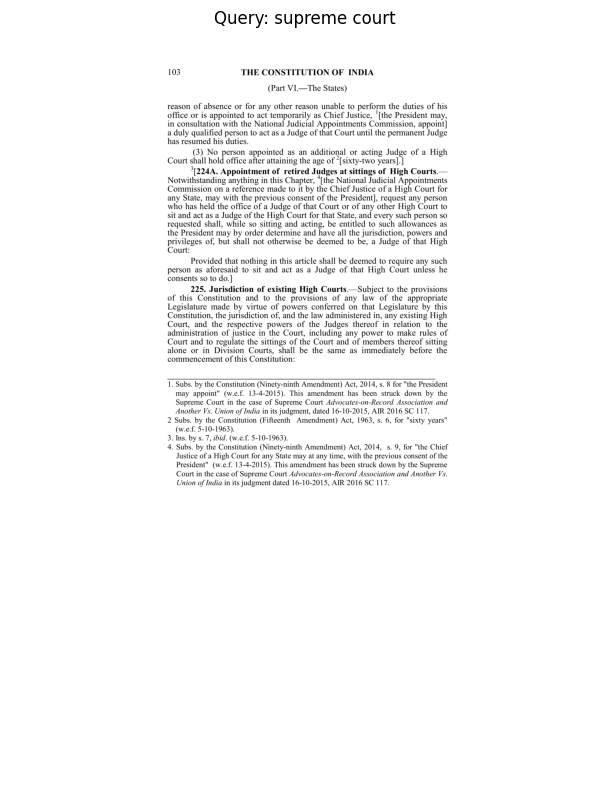

In [ ]:
import fitz
doc = fitz.open(pdf_path)
page = doc.load_page(103 + 30)

img = page.get_pixmap(dpi=300)

doc.close()


img_array = np.frombuffer(img.samples_mv,dtype=np.uint8).reshape((img.height,img.width,img.n))


import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(img_array)
plt.title(f"Query: {query}")
plt.axis("off")
plt.show()


In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [ ]:
query = "Abolition of titles"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 823 embeddings: 0.00006 seconds.


(tensor([0.4981, 0.4620, 0.4465, 0.4266, 0.4221], device='cuda:0'),
 tensor([  7,  94, 711, 704, 120], device='cuda:0'))

In [ ]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 823 embeddings: 0.00006 seconds.
Query: Abolition of titles

Results:
Score: 0.4981
17. Abolition of Untouchability. 18. Abolition of titles.   Right to Freedom
19. Protection of certain rights regarding freedom of speech, etc. 20.
Protection in respect of conviction for offences. 21. Protection of life and
personal liberty.
Page number: -26


Score: 0.4620
363A.  Recognition granted to Rulers of Indian States to cease and privy  purses
to be abolished. 364. Special provisions as to major ports and aerodromes. 365.
Effect of failure to comply with, or to give effect to, directions  given by the
Union.
Page number: -4


Score: 0.4465
6.The Bombay Khoti Abolition Act, 1950 (Bombay Act VI of 1950). 7.The Bombay
Paragana and Kulkarni Watan Abolition Act, 1950  (Bombay Act LX of 1950). 8.The
Madhya Pradesh Abolition of Proprietary Rights (Estates, Mahals,  Alienated
Lands) Act, 1950 (Madhya Pradesh Act I of 1951). 9.The Madras Estates (Abolition
and Conver


## Getting LLM Models in Local generation  

However , This process will also work with LLM API.

What is generative LLM?


#### Checking our Local GPU Memory availability



In [ ]:
### Get GPU available memory
import torch


gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"GPU memory: {gpu_memory_gb:.2f} GB")

GPU memory: 16.00 GB


In [ ]:
!nvidia-smi

Mon Apr  1 22:32:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              50W / 300W |   1834MiB / 16384MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 16 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [ ]:
!pip install transformers

In [ ]:
!pip install --upgrade huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig


quantization_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = "google/gemma-2b-it" # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to(device)

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
# !pip install bitsandbytes

In [ ]:
import torch

torch.cuda.get_device_capability(0)[0]

7

In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5079453696, 'model_mem_mb': 4844.14, 'model_mem_gb': 4.73}

In [ ]:
input_text = "What is the right to speech ?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is the right to speech ?

Prompt (formatted):
<bos><start_of_turn>user
What is the right to speech ?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to(device)
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[    2,     2,   106,  1645,   108,  1841,   603,   573,  1833,   577,
         11360,  1654,   107,   108,   106,  2516,   108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,    573,   1833,
           577,  11360,   1654,    107,    108,    106,   2516,    108,    688,
           651,   1833,    577,  11360,    603,    476,  14127,   1833,  14582,
           731,    573,   5563,  36417,    576,    573,   3520,   3858,  21138,
        116742,    109,    688,    651,   1833,    577,  11360,    688,    603,
           573,  11402,    577,   7055,  63320,  26304,    578,  46183, 235269,
          2346,   3838,  31430, 235265,   1417,   1833,    603,   8727,    604,
           476,   9606,  25886, 235269,    685,    665,   8563,   9278,    577,
          4638,   1024,   5793, 235269,  1

In [ ]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is the right to speech ?<end_of_turn>
<start_of_turn>model
**The right to speech is a fundamental right protected by the First Amendment of the United States Constitution.**

**The right to speech** is the freedom to express oneself freely and openly, without government interference. This right is essential for a healthy democracy, as it allows individuals to share their ideas, opinions, and perspectives, and to participate in the political and social life of their communities.

**The right to speech is not absolute.** There are certain restrictions on speech that are designed to protect public safety, national security, and the rights of others. For example, it is illegal to incite violence, to threaten national security, or to harass or intimidate others.

**The First Amendment to the United States Constitution states:**

> **"Congress shall make no law respecting an establishment of religion, or prohibiting the free exercise

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is the right to speech ?

Output text:
**The right to speech is a fundamental right protected by the First Amendment of the United States Constitution.**

**The right to speech** is the freedom to express oneself freely and openly, without government interference. This right is essential for a healthy democracy, as it allows individuals to share their ideas, opinions, and perspectives, and to participate in the political and social life of their communities.

**The right to speech is not absolute.** There are certain restrictions on speech that are designed to protect public safety, national security, and the rights of others. For example, it is illegal to incite violence, to threaten national security, or to harass or intimidate others.

**The First Amendment to the United States Constitution states:**

> **"Congress shall make no law respecting an establishment of religion, or prohibiting the free exercise of religion, or the free use of religion in any matter whatso

In [ ]:


# Manually created question list
manual_questions = [
    "what is  Annual financial statement",

]

query_list =  manual_questions

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: what is  Annual financial statement
[INFO] Time taken to get scores on 823 embeddings: 0.00014 seconds.


(tensor([0.4578, 0.3879, 0.3799, 0.3567, 0.3467], device='cuda:0'),
 tensor([280, 282, 205, 355, 235], device='cuda:0'))

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fundamental rights guaranteed by the Constitution of India?
Answer: The Constitution of India guarantees several fundamental rights to its citizens, including the right to equality, right to freedom, right against exploitation, right to freedom of religion, cultural and educational rights, and the right to constitutional remedies. These rights are enshrined in Part III of the Constitution and are considered essential for the overall development and well-being of individuals.
\nExample 2:
Query: What is the procedure for amending the Constitution of India?
Answer: The procedure for amending the Constitution of India is outlined in Article 368. An amendment can be initiated by either House of Parliament and requires a special majority, which means it must be passed by a majority of the total membership of each House as well as by a two-thirds majority of the members present and voting. Some amendments also require ratification by the state legislatures.
\nExample 3:
Query: What is the significance of the Preamble to the Constitution of India?
Answer: The Preamble to the Constitution of India serves as a key introductory statement that outlines the aims and objectives of the Constitution. It declares India to be a sovereign, socialist, secular, and democratic republic and emphasizes justice, liberty, equality, and fraternity as its guiding principles. The Preamble reflects the ideals and aspirations of the people of India and provides a moral compass for the nation's governance.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

# # Example usage:
# query = "What are the important features of the Constitution of India?"
# context_items = [
#     {"sentence_chunk": "The Constitution of India was adopted on 26th January 1950."},
#     {"sentence_chunk": "It is the supreme law of India and lays down the framework that defines the political principles, establishes the structure, procedures, powers, and duties of government institutions, and sets out fundamental rights, directive principles, and the duties of citizens."},
#     {"sentence_chunk": "The Constitution of India is the longest written constitution of any country on earth."}
# ]

# generated_prompt = prompt_formatter(query, context_items)
# print(generated_prompt)


In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: what is  Annual financial statement
[INFO] Time taken to get scores on 823 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fundamental rights guaranteed by the Constitution of India?
Answer: The Constitution of India guarantees several fundamental rights to its citizens, including the right to equality, right to freedom, right against exploitation, right to freedom of religion, cultural and educational rights, and the right to constitutional remedies. These rights are enshrined in Part III of the Constitution and are considered essential for the overall development and well-being of individuals.

Example 2

In [ ]:

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: what is  Annual financial statement
RAG answer:
<bos>Sure, here's the answer to the user's query:

An annual financial statement is a document that provides a comprehensive overview of the financial performance of a state in a particular financial year. It typically includes the following components:

- A summary of the state's revenue and expenditure
- A breakdown of the state's financial position, including assets, liabilities, and owner's equity
- A comparison of the state's financial performance to previous years
- A forecast of the state's financial performance for the next fiscal year

The annual financial statement is an essential document for investors, creditors, and other stakeholders to understand the financial health of a state. It provides transparency and accountability, and it allows stakeholders to make informed decisions based on the state's financial information.<eos>


In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
query = "what is  Assent to Bills"
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.2,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
# print(f"Context items:")
# context_items

Query: what is  Assent to Bills
[INFO] Time taken to get scores on 823 embeddings: 0.00009 seconds.
Answer:

According to the context, the procedure for  assent to Bills is outlined in
articles 200 and 201 of the Constitution of India. A Bill must be presented to
the President for assent by the Legislative Assembly or the Governor, and the
President must either assent to the Bill or withhold assent.
